In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from src.embedding import Embedding
from src.forward_kinematics import ForwardKinematic
from src.dynamical_system import DynamicalSystem

# DS

In [2]:
# DS parameters
config_dim = 2
K = 1 * np.eye(config_dim)
D = 1.5*np.eye(config_dim)
# config_attractor = np.array([0.9, -0.9])
config_attractor = np.array([1., 0.15])

# Embedding parameters
# x = torch.tensor([[-0.5], [0.8], [0.]])
x = np.array([[-0.5], [1.8], [0.]])[np.newaxis, :]

fk = ForwardKinematic(urdf_file='2_joints_arm.urdf')

joint_limits = [{'lower': -np.pi/2, 'upper': np.pi/2}, {'lower': -np.pi/2, 'upper': np.pi/2}]
e = Embedding(dimension=2, x=x.repeat(1, 0), fk=fk, limits=joint_limits)

ds = DynamicalSystem(stiffness=K, dissipation=D, attractor=config_attractor, embedding=e, dt=0.01)

In [3]:
# start = np.array([-0.55, 0.85])
start = np.array([0., -0.75])
# start = np.array([-0.5, -1.2])
# initial_speed = np.array([0.1, 0.2])
initial_speed = np.array([0.1, 0.1])
q = start
dq = initial_speed
positions = []
frequencies = []
for i in range(0,8000):
    start1 = time.time()
    q, dq = ds(q, dq)
    positions.append(q)
    frequencies.append(1/(time.time() - start1))
print(f'average execution frequency : {sum(frequencies)/len(frequencies):.4f} Hz')

average execution frequency : 3203.8629 Hz


# FK + Embedding

In [4]:
q1 = np.linspace(joint_limits[0]['lower'], joint_limits[0]['upper'], 100)
q2 = np.linspace(joint_limits[1]['lower'], joint_limits[1]['upper'], 100)
gridX, gridY = np.meshgrid(q1, q2)
grid = np.column_stack((gridX.ravel(), gridY.ravel()))
print(grid.shape)

(10000, 2)


In [5]:
a = np.zeros((grid.shape[0], 3))
freq = []
metrics = np.zeros((grid.shape[0], 2, 2))
gradients = np.zeros((grid.shape[0], 2))
for i, q in enumerate(grid):
    start = time.time()
    p = e.value_only(q).sum()
    embedding, embedding_gradient, embedding_hessian = e.derive(q, np.zeros_like(q))
    metrics[i] = ds.compute_metric(embedding_gradient)
    gradients[i] = embedding_gradient.squeeze()

    a[i] = np.array([q[0], q[1], p])
    freq.append(1/(time.time() - start))
print(f'average freq : {sum(freq)/len(freq)}')

average freq : 3191.061978054857


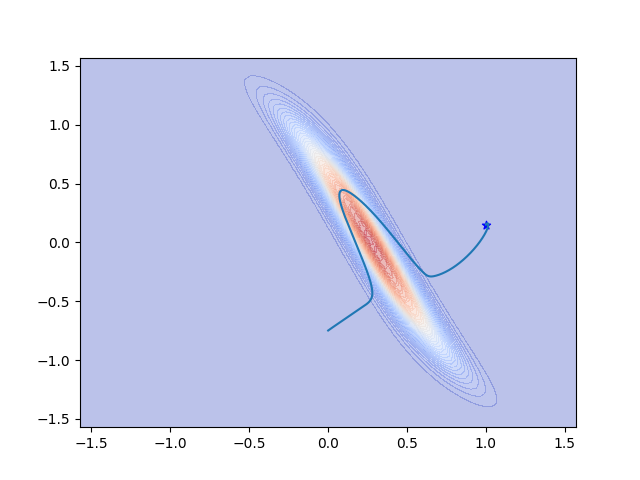

In [6]:
x1 = np.unique(a[:, 0])
x2 = np.unique(a[:, 1])
z = a[:, 2].reshape((x1.shape[0], x2.shape[0]))

ps= np.stack(positions)
%matplotlib widget
plt.figure()
plt.contourf(x1, x2, z, cmap=cm.coolwarm, alpha=0.35, levels=50)
plt.scatter(config_attractor[0], config_attractor[1], label='attractor', marker='*', c='b')
plt.plot(ps[:, 0], ps[:, 1])
plt.xlim([x1.min(), x1.max()])
plt.ylim([x2.min(), x2.max()])
plt.show()

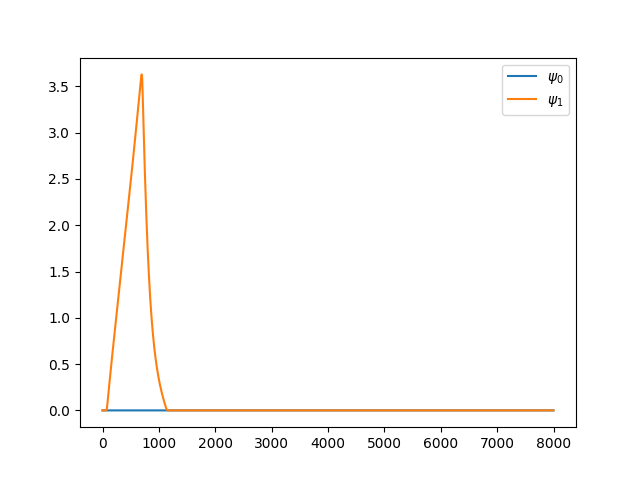

In [8]:
embed =np.stack(ds.embedding_logger)
plt.figure()
plt.plot(range(embed.shape[0]), embed[:, :, 0], label=r'$\psi_0$')
plt.plot(range(embed.shape[0]), embed[:, :, 1], label=r'$\psi_1$')
plt.legend(loc='upper right')
plt.show()

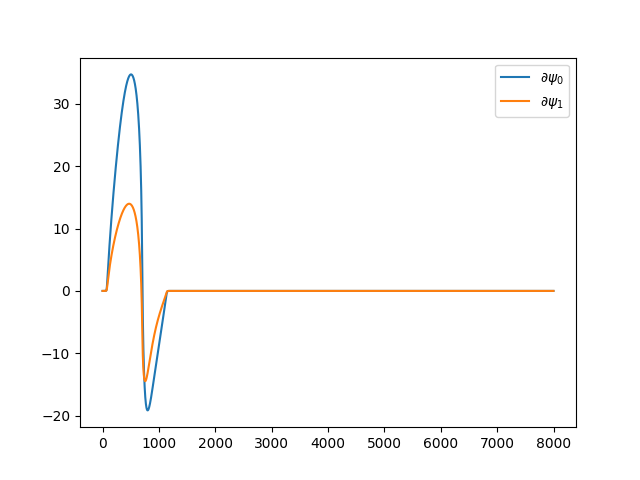

In [9]:
embed =np.stack(ds.gradient_logger)
plt.figure()
plt.plot(range(embed.shape[0]), embed[:, :, 0], label=r'$\partial \psi_{0}$')
plt.plot(range(embed.shape[0]), embed[:, :, 1], label=r'$\partial \psi_{1}$')
plt.legend(loc='upper right')
plt.show()

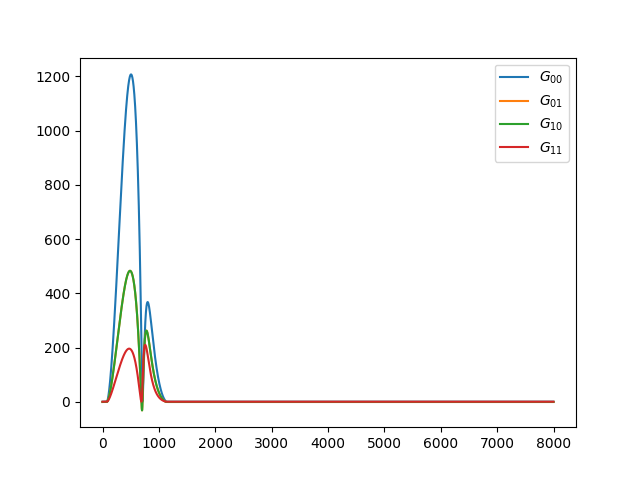

In [10]:
metric = np.stack(ds.metric_logger)
plt.figure()
plt.plot(range(metric.shape[0]), metric[:, 0, 0], label=r'$G_{00}$')
plt.plot(range(metric.shape[0]), metric[:, 0, 1], label=r'$G_{01}$')
plt.plot(range(metric.shape[0]), metric[:, 1, 0], label=r'$G_{10}$')
plt.plot(range(metric.shape[0]), metric[:, 1, 1], label=r'$G_{11}$')
plt.legend(loc='upper right')
plt.show()

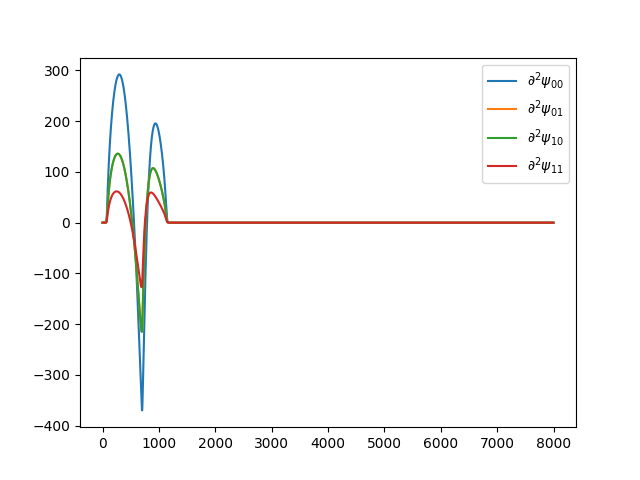

In [11]:
embed =np.stack(ds.hessian_logger)
plt.figure()
plt.plot(range(embed.shape[0]), embed[:, 0, 0], label=r'$\partial^2\psi_{00}$')
plt.plot(range(embed.shape[0]), embed[:, 0, 1], label=r'$\partial^2\psi_{01}$')
plt.plot(range(embed.shape[0]), embed[:, 1, 0], label=r'$\partial^2\psi_{10}$')
plt.plot(range(embed.shape[0]), embed[:, 1, 1], label=r'$\partial^2\psi_{11}$')
plt.legend(loc='upper right')
plt.show()

(8000, 2, 2, 2)


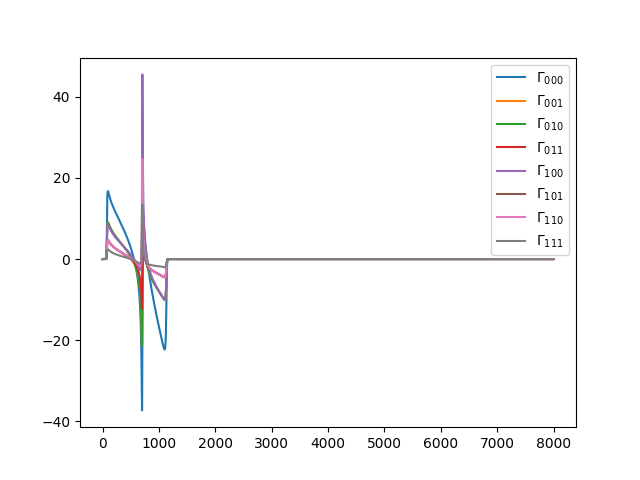

In [12]:
chr = np.stack(ds.christoffel_logger)
print(chr.shape)
plt.figure()
plt.plot(range(chr.shape[0]), chr[:, 0, 0, 0], label=r'$\Gamma_{000}$')
plt.plot(range(chr.shape[0]), chr[:, 0, 0, 1], label=r'$\Gamma_{001}$')
plt.plot(range(chr.shape[0]), chr[:, 0, 1, 0], label=r'$\Gamma_{010}$')
plt.plot(range(chr.shape[0]), chr[:, 0, 1, 1], label=r'$\Gamma_{011}$')
plt.plot(range(chr.shape[0]), chr[:, 1, 0, 0], label=r'$\Gamma_{100}$')
plt.plot(range(chr.shape[0]), chr[:, 1, 0, 1], label=r'$\Gamma_{101}$')
plt.plot(range(chr.shape[0]), chr[:, 1, 1, 0], label=r'$\Gamma_{110}$')
plt.plot(range(chr.shape[0]), chr[:, 1, 1, 1], label=r'$\Gamma_{111}$')
plt.legend(loc='upper right')
plt.show()

(8000, 2, 2, 2)


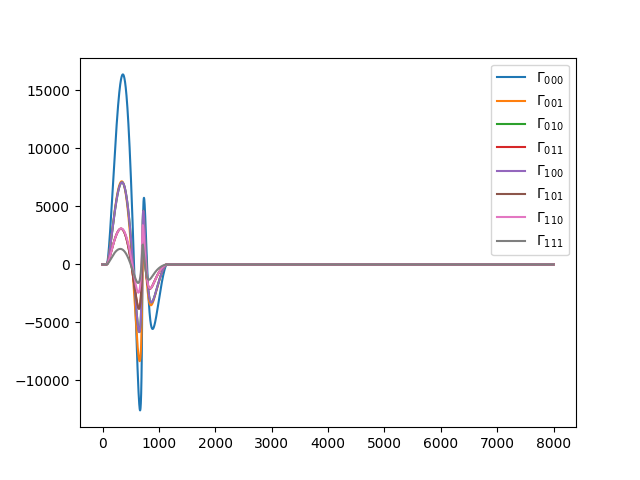

In [13]:
chr = np.stack(ds.forces_logger)
print(chr.shape)
plt.figure()
plt.plot(range(chr.shape[0]), chr[:, 0, 0, 0], label=r'$\Gamma_{000}$')
plt.plot(range(chr.shape[0]), chr[:, 0, 0, 1], label=r'$\Gamma_{001}$')
plt.plot(range(chr.shape[0]), chr[:, 0, 1, 0], label=r'$\Gamma_{010}$')
plt.plot(range(chr.shape[0]), chr[:, 0, 1, 1], label=r'$\Gamma_{011}$')
plt.plot(range(chr.shape[0]), chr[:, 1, 0, 0], label=r'$\Gamma_{100}$')
plt.plot(range(chr.shape[0]), chr[:, 1, 0, 1], label=r'$\Gamma_{101}$')
plt.plot(range(chr.shape[0]), chr[:, 1, 1, 0], label=r'$\Gamma_{110}$')
plt.plot(range(chr.shape[0]), chr[:, 1, 1, 1], label=r'$\Gamma_{111}$')
plt.legend(loc='upper right')
plt.show()

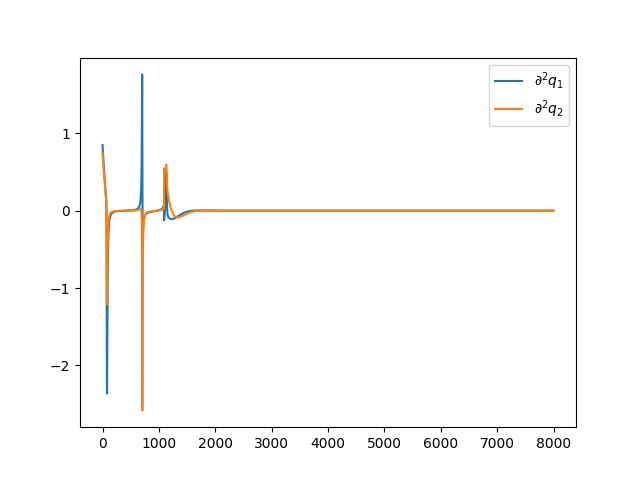

In [14]:
ddx = np.stack(ds.ddx_logger)
plt.figure()
plt.plot(range(ddx.shape[0]), ddx[:, 0], label=r'$\partial^2 q_1$')
plt.plot(range(ddx.shape[0]), ddx[:, 1], label=r'$\partial^2 q_2$')
plt.legend(loc='upper right')
plt.show()

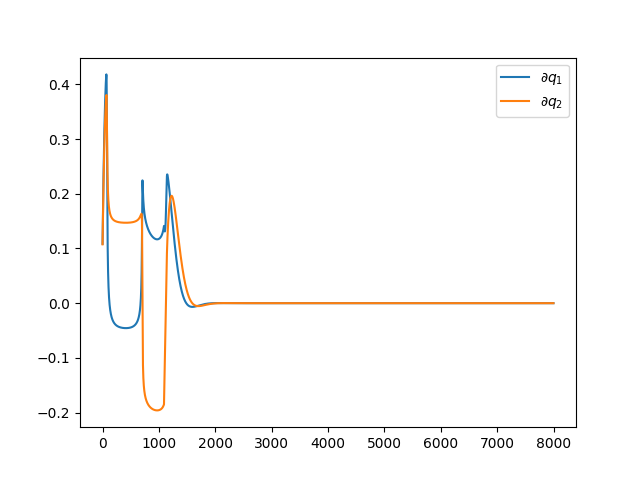

In [15]:
dx = np.stack(ds.dx_logger)
plt.figure()
plt.plot(range(dx.shape[0]), dx[:, 0], label=r'$\partial q_1$')
plt.plot(range(dx.shape[0]), dx[:, 1], label=r'$\partial q_2$')
plt.legend(loc='upper right')
plt.show()

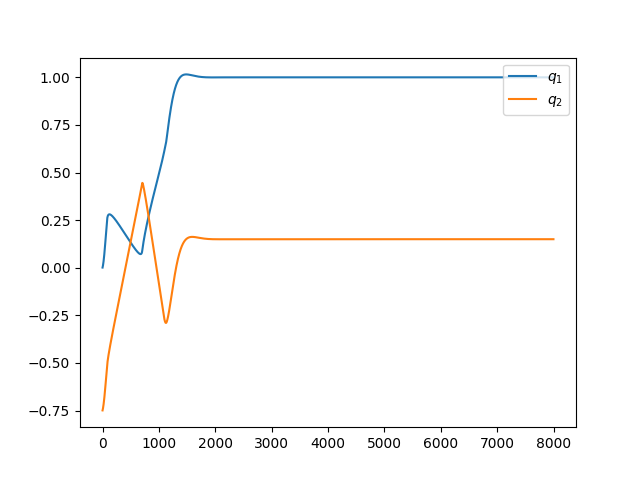

In [16]:
x = np.stack(ds.x_logger)
plt.figure()
plt.plot(range(x.shape[0]), x[:, 0], label=r'$q_1$')
plt.plot(range(x.shape[0]), x[:, 1], label=r'$q_2$')
plt.legend(loc='upper right')
plt.show()

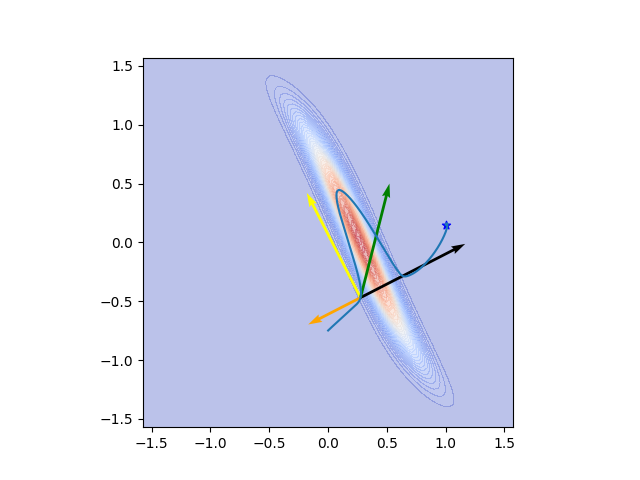

In [17]:
pos = 100

psi = np.stack(ds.embedding_logger)
grad =np.stack(ds.gradient_logger)
hess = np.stack(ds.hessian_logger)

gradient = grad[pos].squeeze()
u = gradient * np.dot(ddx[pos], gradient)/np.linalg.norm(gradient)


%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot()
ax.contourf(x1, x2, z, cmap=cm.coolwarm, alpha=0.35, levels=50)
ax.scatter(config_attractor[0], config_attractor[1], label='attractor', marker='*', c='b')
ax.quiver(ps[pos, 0], ps[pos, 1], grad[pos, :, 0], grad[pos, :, 1], angles='xy', scale_units='xy', scale=np.linalg.norm(grad[pos, :]), color='black')
ax.quiver(ps[pos, 0], ps[pos, 1], -grad[pos, :, 1], grad[pos, :, 0], angles='xy', scale_units='xy', scale=np.linalg.norm(grad[pos, :]), color='yellow')
# plt.quiver(ps[pos, 0], ps[pos, 1], psi[pos, :, 0], psi[pos, :, 1], angles='xy', scale_units='xy', scale=np.linalg.norm(psi[pos, :]), color='red')
ax.quiver(ps[pos, 0], ps[pos, 1], dx[pos, 0], dx[pos, 1], angles='xy', scale_units='xy', scale=np.linalg.norm(dx[pos, :]), color='green')
ax.quiver(ps[pos, 0], ps[pos, 1], ddx[pos, 0], ddx[pos, 1], angles='xy', scale_units='xy', scale=2*np.linalg.norm(ddx[pos, :]), color='orange')
# ax.quiver(ps[pos, 0], ps[pos, 1], u[0], u[1], angles='xy', scale_units='xy', scale=np.linalg.norm(dx[pos]), color='magenta')

ax.plot(ps[:, 0], ps[:, 1])
eps = 0.1
# plt.xlim([-eps+ps[pos, 0], ps[pos, 0] + eps])
# plt.ylim([-eps+ps[pos, 1], ps[pos, 1] + eps])
ax.set_xlim([x1.min(), x1.max()])
ax.set_ylim([x2.min(), x2.max()])
ax.set_aspect('equal')
plt.show()